# **Deep Learning for Atmospheric Pollutant Forecasting: Transformer-Based Approach to Predict Coarse Particulate Matter (PMCO) Concentrations in Mexico City**

## **PREPROCESSING DATA**
### Introduction
---

This notebook is dedicated to the preprocessing of PMCO concentration data from RAMA for the year 2022.
- Steps include data loading, cleaning, outlier removal, missing value imputation, and preparation for further analysis.
- Objective: Prepare data for subsequent analysis and modeling.
- Detailed explanation of each preprocessing step and techniques used.
- End goal: Data in a suitable format for model development and forecasting.

Let's get started with the data preprocessing journey!

## 00 | **Libraries**
---

Imports essential Python libraries for data preprocessing and sets up foundational tools for data manipulation and analysis.

In [2]:
! pip install fancyimpute

In [3]:
! pip install -q datasets gluonts orjson

In [4]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fancyimpute import IterativeImputer
from gluonts.dataset.pandas import PandasDataset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## 01 | **Mounting the Database**
---
This section loads PMCO concentration data from a CSV file, processes it, creates a plot, and saves it as an SVG file.

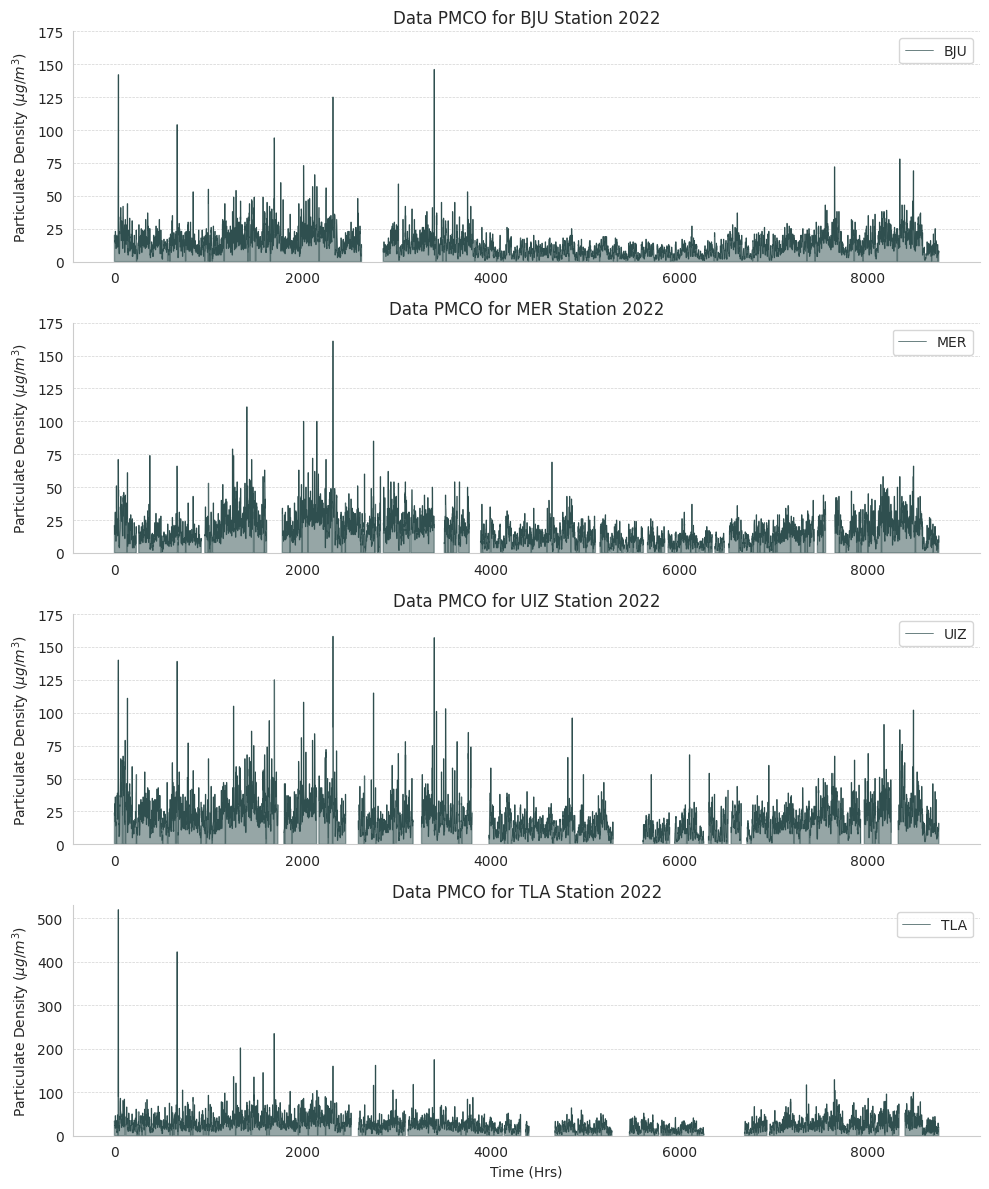

In [5]:
# Read the CSV file
df22 = pd.read_csv("data/2022PMCO.csv")

# Clean and select specific columns
df = df22.drop(['FECHA', 'HORA'], axis=1)
df = df.replace(-99, np.nan)
df = df.loc[:, ['BJU', 'MER', 'UIZ', 'TLA']]

# Set a minimalist style
sns.set_style("whitegrid", {'axes.grid': False})

# Create a figure with four subplots (4 rows, 1 column)
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

colors = {'BJU': 'darkslategray', 'MER': 'darkslategray', 'UIZ': 'darkslategray', 'TLA': 'darkslategray'}

for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], linewidth=0.5, alpha=1, color=colors[column])
    ax.fill_between(df.index, 0, df[column], color=colors[column], alpha=0.5)
    ax.set_title(f'Data PMCO for {column} Station 2022')
    ax.set_ylabel('Particulate Density ($\mu g/m^3$)')
    ax.spines['right'].set_visible(False)  # Remove right border
    ax.spines['top'].set_visible(False)    # Remove top border
    ax.yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)
    ax.legend([column])
    # Check the 'TLA' column to set y-axis limits
    if column == 'TLA':
        ax.set_ylim(0, 530)
    else:
        ax.set_ylim(0, 175)

# Set the xlabel only for the last subplot
axes[-1].set_xlabel('Time (Hrs)')

plt.tight_layout()
plt.show()

# Save the figure as an SVG file
fig.savefig("p001.svg", format="svg")

## 02 | **Outlier Removal**
---
This section removes outliers from the data, calculates statistics before and after the outlier removal, creates plots, and displays statistics for specific stations.

In [6]:
# Create a copy of the original dataframe for comparison before and after outlier removal
df_original = df.copy()

# Calculate the z-score
mean = df.mean()
std_dev = df.std()
z_scores = (df - mean) / std_dev

# Replace outliers with NaN using a z-score threshold (e.g., 3)
df[z_scores.abs() > 3] = np.nan

# Calculate the percentage of data within n standard deviations from the mean for n=1,2,3
for n in range(1, 4):
    within_n_std = ((z_scores.abs() <= n).sum() / len(df)) * 100
    print(f"Percentage of data within ±{n} standard deviations:")
    print(within_n_std)

Percentage of data within ±1 standard deviations:
BJU    72.682648
MER    66.141553
UIZ    64.383562
TLA    70.194064
dtype: float64
Percentage of data within ±2 standard deviations:
BJU    93.127854
MER    84.691781
UIZ    82.888128
TLA    82.157534
dtype: float64
Percentage of data within ±3 standard deviations:
BJU    95.205479
MER    86.929224
UIZ    84.531963
TLA    83.972603
dtype: float64


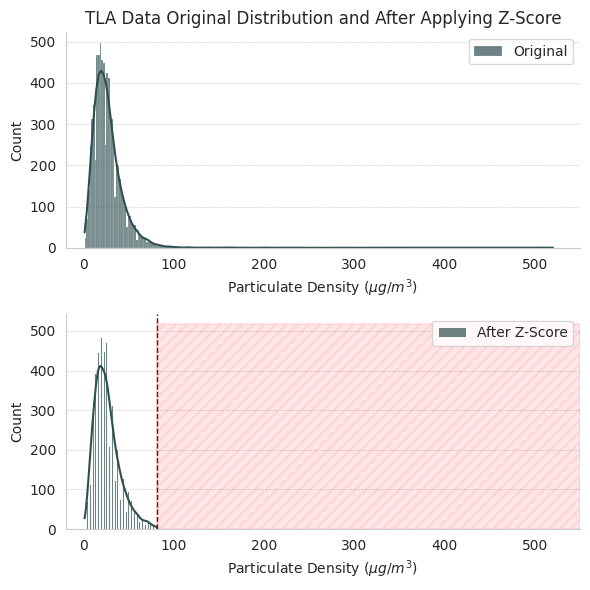

In [7]:
# Find the maximum value in df['TLA']
max_val = df['TLA'].max()
max_val_or = df_original['TLA'].max()

# Set a minimalist style
sns.set_style("whitegrid", {'axes.grid': False})

fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Original data distribution plot
sns.histplot(df_original['TLA'], ax=ax[0], kde=True, color='darkslategray', label='Original', alpha=0.7)
ax[0].set_title('TLA Data Original Distribution and After Applying Z-Score')
ax[0].legend()
ax[0].set_xlabel('Particulate Density ($\mu g/m^3$)')
ax[0].set_xlim(-20, 550)
ax[0].spines['right'].set_visible(False)  # Remove right border
ax[0].spines['top'].set_visible(False)    # Remove top border
ax[0].yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)

# Distribution plot after removing outliers
sns.histplot(df['TLA'], ax=ax[1], kde=True, color='darkslategray', label='After Z-Score', alpha=0.7)
ax[1].legend()
ax[1].set_xlabel('Particulate Density ($\mu g/m^3$)')
ax[1].set_xlim(-20, 550)
ax[1].spines['right'].set_visible(False)  # Remove right border
ax[1].spines['top'].set_visible(False)    # Remove top border
ax[1].yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)
ax[1].axvline(max_val, color='darkred', linestyle='--', linewidth=1)  # Line

# Fill with solid red color in hatches
ymin, ymax = ax[1].get_ylim()
ax[1].fill_betweenx(np.arange(ymin, ymax, 0.01), max_val, 550, color='red', alpha=0.1, hatch='///')

# Adjust subplot layout
plt.tight_layout()
plt.show()

# Save the figure as a PNG file
fig.savefig("p002.png", format="png")

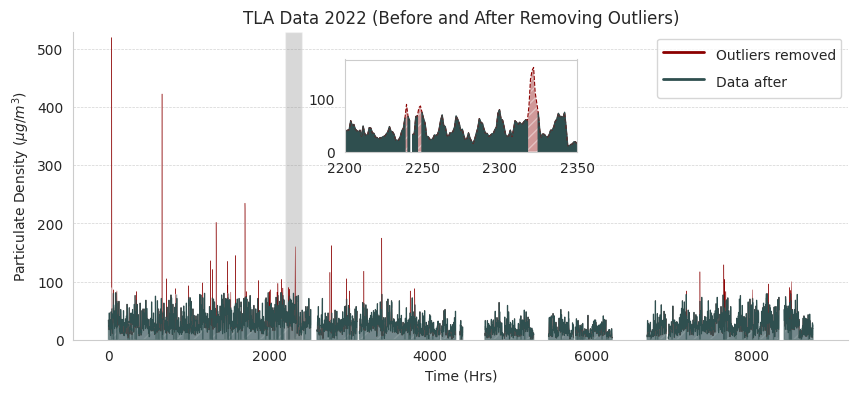

In [8]:
# Set a minimalist style
sns.set_style("whitegrid", {'axes.grid': False})

fig, ax = plt.subplots(figsize=(10, 4))

# Plot the original data
line1, = ax.plot(df_original.index, df_original['TLA'], linewidth=0.3, alpha=1, label='Outliers removed', color='darkred')
# Fill with diagonal lines for original data
ax.fill_between(df_original.index, 0, df_original['TLA'], facecolor='lightslategray', alpha=0.5, hatch='//')

# Plot the data after removing outliers
line2, = ax.plot(df.index, df['TLA'], linewidth=0.5, alpha=1, label='Data after', color='darkslategray')
ax.fill_between(df.index, 0, df['TLA'], color='darkslategray', alpha=0.5)

# Mark in gray the range where you are taking the small plot
ax.axvspan(2200, 2400, facecolor='grey', alpha=0.3)

# Legend configuration
legend = ax.legend(loc='upper right', handlelength=3, handleheight=2, labelspacing=0.4)
for handle in legend.legend_handles:
    handle.set_linewidth(2)

ax.set_title('TLA Data 2022 (Before and After Removing Outliers)')
ax.set_xlabel('Time (Hrs)')
ax.set_ylabel('Particulate Density ($\mu g/m^3$)')
ax.set_ylim(0, 530)

# Borders and grid configuration
ax.spines['right'].set_visible(False)  # Remove right border
ax.spines['top'].set_visible(False)    # Remove top border
ax.yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)

# Create an enlarged plot
axins = inset_axes(ax, width='30%', height='30%', loc='upper center', borderpad=2)
axins.plot(df_original.index, df_original['TLA'], linestyle='--', linewidth=0.8, alpha=1, color='darkred')
axins.fill_between(df_original.index, 0, df_original['TLA'], facecolor='darkred', alpha=0.4, hatch='///')
axins.plot(df.index, df['TLA'], linewidth=0.6, alpha=1, color='darkslategray')
axins.fill_between(df.index, 0, df['TLA'], color='darkslategray', alpha=1)
axins.set_xlim(2200, 2350)  # Set x-axis limits for the enlarged plot
axins.set_ylim(0, 175)  # Set y-axis limits for the enlarged plot

plt.show()

# Save the figure as a PNG file
fig.savefig("p003.png", format="png", bbox_inches='tight')  # Añade bbox_inches para un mejor ajuste


In [9]:
# Suppose you have already identified stations as 'good_stations'. Replace with actual station names.
good_stations = ['BJU', 'MER', 'UIZ', 'TLA']

# Create a list to store metrics data for each station
data = []

# Get metrics for each station and add them to the data list
for station in good_stations:
    min_val = df[station].min()
    max_val = df[station].max()
    mean_val = df[station].mean()
    std_val = df[station].std()
    missing_values = df[station].isna().sum()

    data.append([station, min_val, max_val, mean_val, std_val, missing_values])

# Create a DataFrame with the data
columns = ['Stations', 'Min(μg/m^3)', 'Max(μg/m^3)', 'Mean(μg/m^3)', 'σ(μg/m^3)', 'Missing Values']
stats_df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
print(stats_df)

  Stations  Min(μg/m^3)  Max(μg/m^3)  Mean(μg/m^3)  σ(μg/m^3)  Missing Values
0      BJU          1.0         39.0     12.761271   7.249826             420
1      MER          1.0         48.0     16.647932   9.145520            1145
2      UIZ          1.0         58.0     19.026874  10.580093            1355
3      TLA          1.0         81.0     25.924144  14.191521            1404


In [10]:
df

,BJU,MER,UIZ,TLA
0,20.0,21.0,24.0,34.0
1,20.0,20.0,23.0,32.0
2,18.0,19.0,22.0,31.0
3,16.0,14.0,23.0,25.0
4,15.0,15.0,31.0,23.0
...,...,...,...,...
8755,7.0,10.0,11.0,19.0
8756,8.0,9.0,12.0,19.0
8757,7.0,8.0,15.0,19.0
8758,8.0,13.0,16.0,19.0


## 03 | **Missing Value Imputation**
---

This section replaces missing values represented as -99 with NaN, imputes missing data using the IterativeImputer, adds date columns to the data, and creates plots to visualize the imputed data alongside the actual data for each station.


In [11]:
# Replace -99 with NaN
df = df.replace(-99, np.nan)

In [12]:
# Create an IterativeImputer object
mice_imputer = IterativeImputer(min_value=0, tol=0.01)
# Impute missing data
df_mice = pd.DataFrame(mice_imputer.fit_transform(df), columns=df.columns)
df_mice

,BJU,MER,UIZ,TLA
0,20.0,21.0,24.0,34.0
1,20.0,20.0,23.0,32.0
2,18.0,19.0,22.0,31.0
3,16.0,14.0,23.0,25.0
4,15.0,15.0,31.0,23.0
...,...,...,...,...
8755,7.0,10.0,11.0,19.0
8756,8.0,9.0,12.0,19.0
8757,7.0,8.0,15.0,19.0
8758,8.0,13.0,16.0,19.0


In [13]:
# Add dates
df.insert(0, 'Date', pd.date_range(start='2022-01-01 00:00:00', periods=8760, freq='H'))
df_mice.insert(0, 'Date', pd.date_range(start='2022-01-01 00:00:00', periods=8760, freq='H'))

In [14]:
df_mice

,Date,BJU,MER,UIZ,TLA
0,2022-01-01 00:00:00,20.0,21.0,24.0,34.0
1,2022-01-01 01:00:00,20.0,20.0,23.0,32.0
2,2022-01-01 02:00:00,18.0,19.0,22.0,31.0
3,2022-01-01 03:00:00,16.0,14.0,23.0,25.0
4,2022-01-01 04:00:00,15.0,15.0,31.0,23.0
...,...,...,...,...,...
8755,2022-12-31 19:00:00,7.0,10.0,11.0,19.0
8756,2022-12-31 20:00:00,8.0,9.0,12.0,19.0
8757,2022-12-31 21:00:00,7.0,8.0,15.0,19.0
8758,2022-12-31 22:00:00,8.0,13.0,16.0,19.0


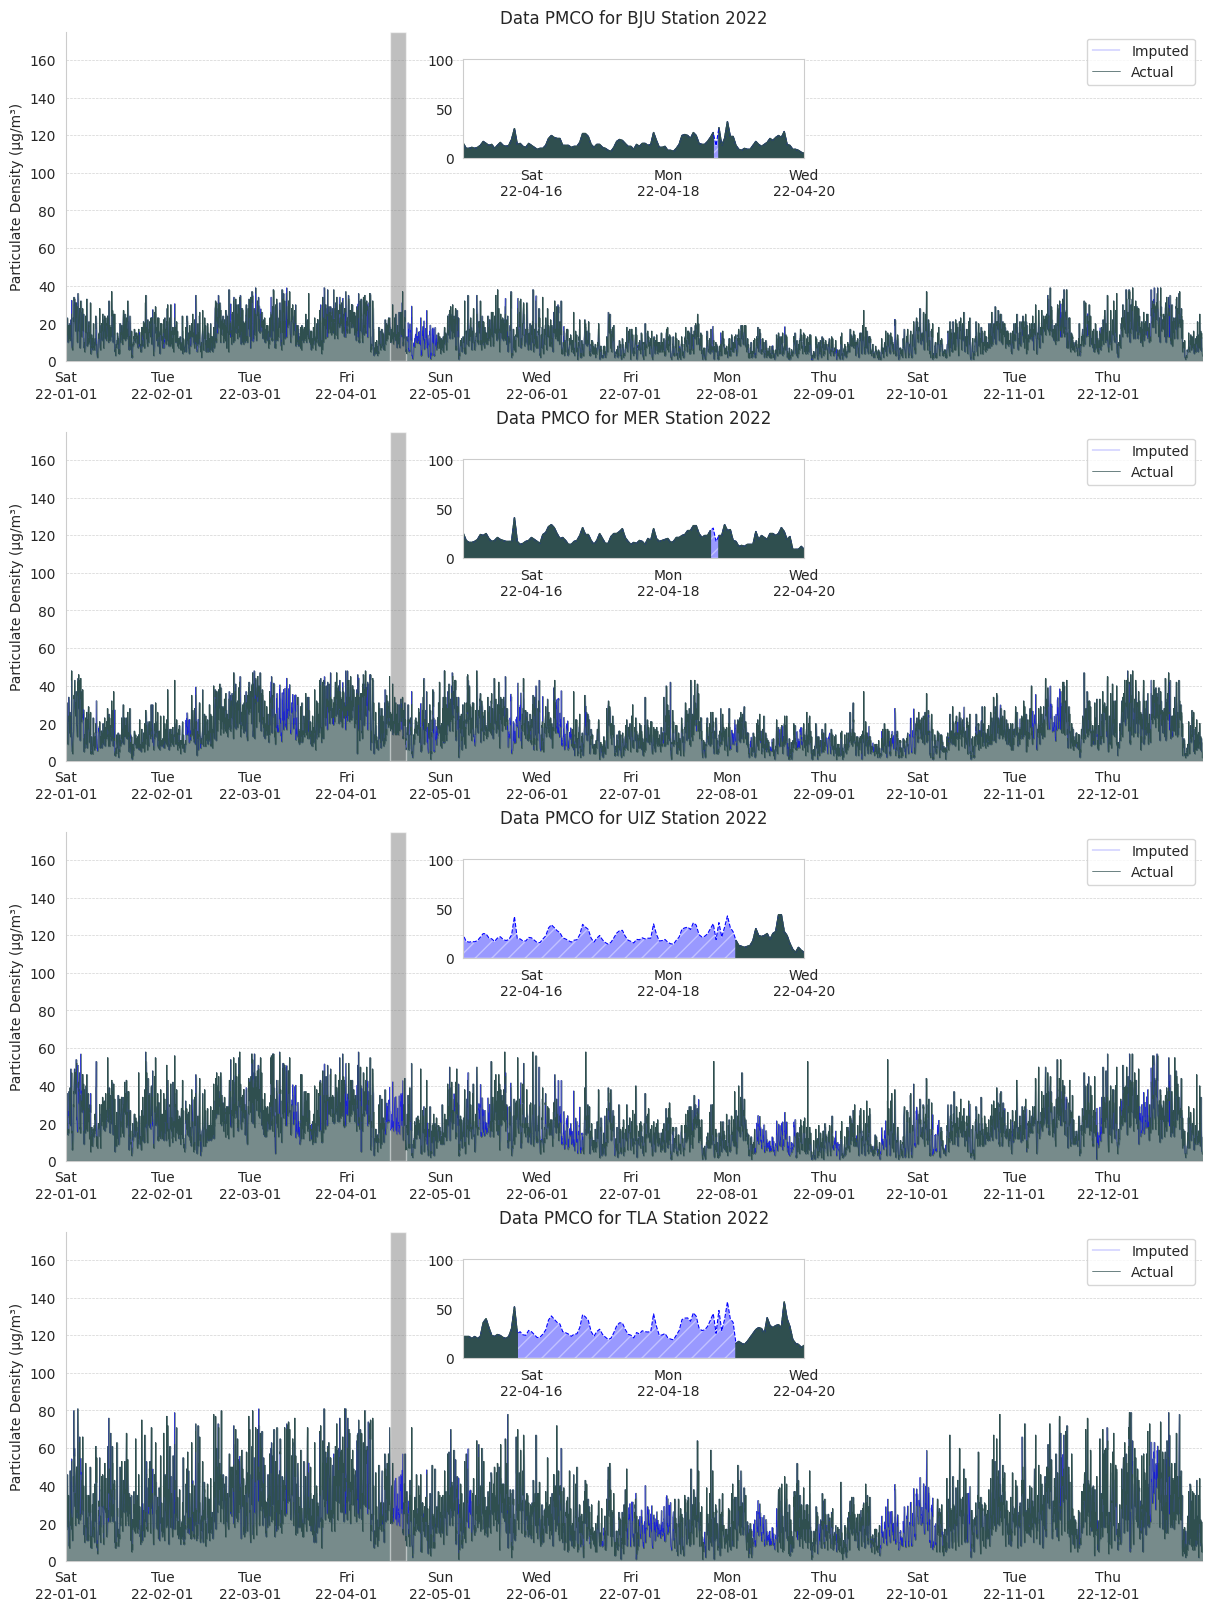

In [15]:
# Function to plot data
def plot_data_imputed(station, start, end, ax):
    # Set minimalistic style
    sns.set_style("whitegrid", {'axes.grid': False})

    # Dark colors by station
    colors_dark = {'BJU': 'darkslategray', 'MER': 'darkslategray', 'UIZ': 'darkslategray', 'TLA': 'darkslategray'}

    # Fill for imputed data
    ax.fill_between(df['Date'], 0, df_mice[station], color='darkslategray', alpha=0.3)

    # Plot imputed data
    ax.plot(df['Date'], df_mice[station], linewidth=0.3, color='blue', alpha=0.7, label='Imputed')

    # Fill for actual data
    ax.fill_between(df['Date'], 0, df_mice[station], color='darkslategray', alpha=0.5)

    # Plot actual data using the corresponding dark color
    ax.plot(df['Date'], df[station], linewidth=0.5, color=colors_dark[station], alpha=1, label='Actual')

    # Design settings
    ax.set_xlim(pd.Timestamp(start), pd.Timestamp(end))
    ax.set_ylim(0, 175)
    ax.set_ylabel('Particulate Density (µg/m³)')
    ax.set_title(f'Data PMCO for {station} Station 2022')
    ax.yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)
    ax.spines['right'].set_visible(False)  # Remove right border
    ax.spines['top'].set_visible(False)    # Remove top border
    ax.legend()

    # Main tick labels format (e.g., '2023-08-18')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%y-%m-%d'))

    ax.axvspan(pd.Timestamp('2022-04-15'), pd.Timestamp('2022-04-20'), facecolor='grey', alpha=0.5)

    # Create an inset plot
    axins = inset_axes(ax, width='30%', height='30%', loc='upper center', borderpad=2)
    axins.plot(df['Date'], df_mice[station], linestyle='--', linewidth=0.8, alpha=1, color='blue')

    # Fill for actual data in the inset plot
    axins.fill_between(df['Date'], 0, df_mice[station], facecolor='blue', alpha=0.4, hatch='//')
    axins.fill_between(df['Date'], 0, df[station], color='darkslategray', alpha=1)

    axins.plot(df['Date'], df[station], linewidth=1, color=colors_dark[station])
    axins.set_xlim(pd.Timestamp('2022-04-15'), pd.Timestamp('2022-04-20'))
    axins.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    axins.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%y-%m-%d'))
    axins.set_ylim(0, 100)  # Set the y-axis limits for the inset plot


# Create a figure with four subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 16), constrained_layout=True)

stations = ['BJU', 'MER', 'UIZ', 'TLA']
start_date = '2022-01-01'
end_date = '2022-12-31'

for ax, station in zip(axes, stations):
    plot_data_imputed(station, start_date, end_date, ax)

plt.show()

# Save the figure as a PNG file
fig.savefig("p004.png", format="png")

## 04 | **Preparing the Final Dataset**
---
This section of code assigns the imputed DataFrame `df_mice` to `df`, creates individual DataFrames for each station (BJU, MER, UIZ, TLA), renames columns, sets indices, and adds an 'Est' column for each station. Finally, it concatenates all station DataFrames into a single DataFrame 'df'.

In [16]:
# Assign the imputed DataFrame to df
df = df_mice
#df = df.iloc[:7008]
df

,Date,BJU,MER,UIZ,TLA
0,2022-01-01 00:00:00,20.0,21.0,24.0,34.0
1,2022-01-01 01:00:00,20.0,20.0,23.0,32.0
2,2022-01-01 02:00:00,18.0,19.0,22.0,31.0
3,2022-01-01 03:00:00,16.0,14.0,23.0,25.0
4,2022-01-01 04:00:00,15.0,15.0,31.0,23.0
...,...,...,...,...,...
8755,2022-12-31 19:00:00,7.0,10.0,11.0,19.0
8756,2022-12-31 20:00:00,8.0,9.0,12.0,19.0
8757,2022-12-31 21:00:00,7.0,8.0,15.0,19.0
8758,2022-12-31 22:00:00,8.0,13.0,16.0,19.0


In [17]:
# Create individual DataFrames for each station (BJU, MER, UIZ, TLA)
# Rename the column to 'PMCO', set the index, and add the 'Est' column
dfBJU = df.loc[:, ['BJU']]
dfBJU = dfBJU.rename(columns={'BJU': 'PMCO'})
dfBJU.index = pd.date_range(start='2021-01-01', periods=len(dfBJU), freq='H')
dfBJU['Est'] = 'BJU'

dfMER = df.loc[:, ['MER']]
dfMER = dfMER.rename(columns={'MER': 'PMCO'})
dfMER.index = pd.date_range(start='2021-01-01', periods=len(dfMER), freq='H')
dfMER['Est'] = 'MER'

dfUIZ = df.loc[:, ['UIZ']]
dfUIZ = dfUIZ.rename(columns={'UIZ': 'PMCO'})
dfUIZ.index = pd.date_range(start='2021-01-01', periods=len(dfUIZ), freq='H')
dfUIZ['Est'] = 'UIZ'

dfTLA = df.loc[:, ['TLA']]
dfTLA = dfTLA.rename(columns={'TLA': 'PMCO'})
dfTLA.index = pd.date_range(start='2021-01-01', periods=len(dfTLA), freq='H')
dfTLA['Est'] = 'TLA'


#dfMER.head()

In [18]:
# Concatenate all station DataFrames into a single DataFrame 'df'
df = pd.concat([dfBJU, dfMER, dfUIZ, dfTLA], axis=0, ignore_index=False)
df

,PMCO,Est
2021-01-01 00:00:00,20.0,BJU
2021-01-01 01:00:00,20.0,BJU
2021-01-01 02:00:00,18.0,BJU
2021-01-01 03:00:00,16.0,BJU
2021-01-01 04:00:00,15.0,BJU
...,...,...
2021-12-31 19:00:00,19.0,TLA
2021-12-31 20:00:00,19.0,TLA
2021-12-31 21:00:00,19.0,TLA
2021-12-31 22:00:00,19.0,TLA


In [19]:
df.to_csv('df.csv', index=True)